# Graph Creation

This notebook focuses on the construction and evaluation of a directed career transition graph using historical employment data. The core objective is to model professional journeys as a probabilistic network where nodes represent job titles and edges represent transitions. To find the "optimal" career path, we transform transition probabilities $P(B|A)$ into a cost function using the formula $Weight = -\ln(P(B|A)) + \gamma$. By applying Dijkstra’s Algorithm to these additive weights, the system effectively identifies the maximum-likelihood path between any two roles, balanced by a $\gamma$ (gamma) penalty that discourages excessively long sequences of transitions.

In [1]:
import pandas as pd
from datasets import load_dataset
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
# Load the raw transition dataset
df = pd.read_csv('/content/hops_jobs.csv')

# Standardize role names to lowercase and remove whitespace for consistent matching
df['matched_label'] = df['matched_label'].str.lower().str.strip()

In [3]:
# Define keywords to isolate the Tech and Data science ecosystem

keywords = [
    # 'unknown',
    # Core Data & AI
    'data', 'ai', 'ml', 'machine learning', 'artificial intelligence',
    'analytics', 'business intelligence', 'bi', 'data science',
    'deep learning', 'nlp', 'computer vision', 'prompt engineer',

    # Software & Development
    'software', 'engineer', 'developer', 'dev', 'programmer',
    'backend', 'frontend', 'fullstack', 'full stack', 'web dev',

    # Infrastructure & Databases
    'db', 'dba', 'database', 'sql', 'nosql', 'data warehouse',
    'cloud', 'aws', 'azure', 'gcp', 'devops', 'sre', 'platform engineer',

    # Management & Strategy
    'product manager', 'product management', 'tech lead',
    'engineering manager', 'cto', 'architect', 'product owner'
]

# Use regex to filter for roles that contain our target keywords
pattern = '|'.join([rf'\b{k}\b' for k in keywords])


df = df[df['matched_label'].str.contains(pattern, case=False, na=False)].copy()

print(f"Total rows in original data: {len(df)}")

Total rows in original data: 3057


In [4]:
df['matched_label'].unique()

array(['ict product manager', 'data warehouse designer',
       'ict network engineer', 'venue programmer', 'steam engineer',
       'ship assistant engineer', 'industrial tool design engineer',
       'contract engineer', 'heating and ventilation service engineer',
       'pharmaceutical engineer', 'quality engineer',
       'ict application developer', 'web developer', 'data entry clerk',
       'database integrator', 'big data archive librarian',
       'research engineer', 'data analyst', 'data scientist',
       'software tester',
       'wholesale merchant in computers, computer peripheral equipment and software',
       'computer games, multimedia and software specialised seller',
       'application engineer', 'software manager',
       'data quality specialist', 'software developer',
       'logistics engineer', 'intelligent lighting engineer',
       'commissioning engineer', 'landscape architect',
       'business developer', 'mobile application developer',
       'sound mas

### Data Transformation

In [5]:
# Remove invalid entries and 'unknown' placeholders to clean the graph nodes
df = df.dropna(subset=['start_date']).copy()
df = df[df['matched_label'] != 'unknown']
def convert_quarter_to_date(q_str):
    # Mapping Q1 -> Jan, Q2 -> Apr, Q3 -> Jul, Q4 -> Oct
    quarter_map = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}
    q, year = q_str.split(' ')
    return pd.to_datetime(f"{year}-{quarter_map[q]}-01")

df['start_date_dt'] = df['start_date'].apply(convert_quarter_to_date)

In [6]:
from pandas.tseries.offsets import DateOffset

# --- GENESIS STEP ---
# Inject a dummy 'unemployed' role 3 months prior to each person's first recorded job.
# This allows the graph to model entry-level transitions from a common starting state.
df = df.sort_values(['person_id', 'start_date_dt'])
first_jobs = df.groupby('person_id').head(1).copy()
unemployed_rows = first_jobs.copy()
unemployed_rows['matched_label'] = 'unemployed'
unemployed_rows['start_date_dt'] = unemployed_rows['start_date_dt'] - DateOffset(months=3)
unemployed_rows['start_date'] = "Genesis"
df = pd.concat([df, unemployed_rows], ignore_index=True)
# --- END: GENESIS STEP ---

In [7]:
# Identify the chronological 'next_role' for every user
df_sorted = df.sort_values(['person_id', 'start_date_dt'])
df_sorted['next_role'] = df_sorted.groupby('person_id')['matched_label'].shift(-1)
transitions = df_sorted.dropna(subset=['next_role']).copy()

In [8]:
# Count occurrences of each A -> B transition
edge_counts = transitions.groupby(['matched_label', 'next_role']).size().reset_index(name='count_AB')

# Calculate the transition probability P(B|A)
role_out_totals = edge_counts.groupby('matched_label')['count_AB'].transform('sum')
edge_counts['probability'] = edge_counts['count_AB'] / role_out_totals


# Transform probabilities into additive costs: -log(P) + gamma
gamma = 1.01

# Calculate weight for Dijkstra
# gamma acts as a length penalty to prefer shorter, higher-probability paths.
edge_counts['weight'] = -np.log(edge_counts['probability']) + gamma

In [9]:
edge_counts = edge_counts.rename(columns={
    'matched_label': 'From A',
    'next_role': 'To B',
    'count_AB': 'transition_count'
})

edge_counts

,From A,To B,transition_count,probability,weight
0,acoustical engineer,acoustical engineer,1,1.000000,1.010000
1,agricultural engineer,agricultural engineer,1,0.500000,1.703147
2,agricultural engineer,calculation engineer,1,0.500000,1.703147
3,airport planning engineer,chief data officer,1,1.000000,1.010000
4,application engineer,application engineer,1,0.071429,3.649057
...,...,...,...,...,...
700,web developer,web developer,11,0.275000,2.300984
701,"wholesale merchant in computers, computer peri...",product manager,1,0.333333,2.108612
702,"wholesale merchant in computers, computer peri...",telecommunications engineer,1,0.333333,2.108612
703,"wholesale merchant in computers, computer peri...","wholesale merchant in computers, computer peri...",1,0.333333,2.108612


In [10]:
# Initialize the Directed Graph
G = nx.DiGraph()

# Build the graph using the transformed costs
for _, row in edge_counts.iterrows():
    G.add_edge(
        row['From A'],
        row['To B'],
        weight=row['weight'],           # The cost for Dijkstra's minimization (-log(P) + gamma)
        probability=row['probability'], # For path confidence calculation
        count=row['transition_count']   # Confidence metric based on sample size
    )

print(f"Graph Construction Complete: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

Graph Construction Complete: 171 nodes, 705 edges.


# End of Graph Creation

# Dikstra search on graph

In [11]:
def find_wannabe_path(graph, current_role, target_role):
    """
    Finds the career roadmap that maximizes overall likelihood while
    minimizing total steps.
    """
    try:
        # Compute the path that minimizes the sum of costs (-log probabilities)
        path = nx.shortest_path(graph, source=current_role, target=target_role, weight='weight')

        print(f"--- Recommended Career Path ---")

        # Joining the list of roles with an arrow for a quick "A -> B -> C" view.
        path_summary = " → ".join(path)
        print(f"The Shortest Path: {path_summary}")
        print(f"Goal: {current_role} → {target_role}")
        print("-" * 50 + "\n")

        total_probability = 1.0

        # Display detailed metrics for each transition step
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            step_data = graph[u][v]

            # Cumulative likelihood is the product of step probabilities
            total_probability *= step_data['probability']

            print(f"Step {i+1}: {u} → {v}")
            print(f"Transition Likelihood: {step_data['probability']:.2%}")
            print(f"Historical Transitions Observed: {step_data['count']}")
            print("-" * 35)

        # Final path completion and confidence score
        print(f"Path Completed!")
        print(f"Overall Path Confidence: {total_probability:.4%}")

        return path

    except nx.NetworkXNoPath:
        # Handle cases where no transition sequence exists in the historical data
        print(f"No realistic path found between '{current_role}' and '{target_role}' in historical data.")
        return None
    except nx.NodeNotFound:
        # Ensure input resolution correctly mapped the user's role to a graph node
        print(f"Error: One or both roles not found in the graph. Please check exact naming.")
        return None

In [12]:
# Example Usage
my_path = find_wannabe_path(G, "data analyst", "data scientist")

--- Recommended Career Path ---
The Shortest Path: data analyst → data entry supervisor → software developer → data scientist
Goal: data analyst → data scientist
--------------------------------------------------

Step 1: data analyst → data entry supervisor
Transition Likelihood: 5.88%
Historical Transitions Observed: 1
-----------------------------------
Step 2: data entry supervisor → software developer
Transition Likelihood: 25.00%
Historical Transitions Observed: 1
-----------------------------------
Step 3: software developer → data scientist
Transition Likelihood: 1.23%
Historical Transitions Observed: 1
-----------------------------------
Path Completed!
Overall Path Confidence: 0.0182%


In [13]:
my_path = find_wannabe_path(G, "software developer", "data scientist")

--- Recommended Career Path ---
The Shortest Path: software developer → data scientist
Goal: software developer → data scientist
--------------------------------------------------

Step 1: software developer → data scientist
Transition Likelihood: 1.23%
Historical Transitions Observed: 1
-----------------------------------
Path Completed!
Overall Path Confidence: 1.2346%


In [14]:
import pickle

# Save the graph to a file
with open('wannabe_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

print("Graph saved successfully as 'wannabe_graph.pkl'")

Graph saved successfully as 'wannabe_graph.pkl'


# Graph Gamma Selection & Evaluation

In [15]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the Directed Graph
G = nx.DiGraph()

# Build the graph using ONLY the raw probability costs
for _, row in edge_counts.iterrows():
    G.add_edge(
        row['From A'],
        row['To B'],
        # Dijkstra finds the MINIMUM sum.
        # -log(P) turns a high probability (0.9) into a low cost (0.1)
        raw_log_p = -np.log(row['probability']),
        probability = row['probability']
    )

print(f"Graph Ready: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

Graph Ready: 171 nodes, 705 edges.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random

# PREPARE ACCESSIBLE TRANSITION DATA ---
# Ensure we have the counts and reset the index to keep columns accessible for the test set
edge_counts = transitions.groupby(['matched_label', 'next_role']).size().reset_index(name='count_AB')

# Rename explicitly to match the graph building logic
edge_counts = edge_counts.rename(columns={
    'matched_label': 'From A',
    'next_role': 'To B',
    'count_AB': 'transition_count'
})


In [17]:
def evaluate_next_step_accuracy(graph, transitions_df, gamma_values, n_samples=200):

    test_samples = transitions_df.sample(
        min(n_samples, len(transitions_df)),
        random_state=42
    )

    results = []

    for g in gamma_values:

        # Set eval_weight safely using precomputed raw_log_p
        for u, v, d in graph.edges(data=True):
            d["eval_weight"] = d["raw_log_p"] + g

        hits = 0
        total_valid = 0
        path_lengths = []

        for _, row in test_samples.iterrows():
            src = row["matched_label"]
            dst = row["next_role"]

            if src not in graph or dst not in graph:
                continue

            try:
                path = nx.shortest_path(
                    graph,
                    source=src,
                    target=dst,
                    weight="eval_weight"
                )

                if len(path) > 1 and path[1] == dst:
                    hits += 1

                total_valid += 1
                path_lengths.append(len(path) - 1)

            except nx.NetworkXNoPath:
                continue

        results.append({
            "gamma": g,
            "Next-Step Accuracy": hits / total_valid if total_valid else 0,
            "Avg Steps to Goal": np.mean(path_lengths) if path_lengths else np.nan
        })

    return pd.DataFrame(results)


In [18]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

def evaluate_multi_step_performance(graph, df_sorted, gamma_values, n_samples=100):
    """
    Evaluates accuracy on long-term journeys (Start -> ... -> Target).
    This reveals the trade-off between path efficiency and real-world accuracy.
    """
    # Sample users with at least 3 distinct roles in their history
    person_counts = df_sorted.groupby('person_id').size()
    valid_ids = person_counts[person_counts >= 3].index
    np.random.seed(52)

    results = []

    for g in gamma_values:
        # Update graph weights using the cost function: -log(P) + gamma
        for u, v, d in graph.edges(data=True):
            d["eval_weight"] = -np.log(d['probability']) + g

        hits, total_valid, path_lengths = 0, 0, []

        # Sample random long-term journeys
        sampled_ids = np.random.choice(valid_ids, min(n_samples, len(valid_ids)), replace=False)

        for p_id in sampled_ids:
            user_roles = df_sorted[df_sorted['person_id'] == p_id]['matched_label'].tolist()
            src, target, actual_next = user_roles[0], user_roles[-1], user_roles[1]

            if src not in graph or target not in graph: continue

            try:
                # Find the optimal roadmap from Start to Final Goal
                path = nx.shortest_path(graph, src, target, weight="eval_weight")

                # Check if the first step of the roadmap matches the user's actual next move
                if len(path) > 1 and path[1] == actual_next:
                    hits += 1

                total_valid += 1
                path_lengths.append(len(path) - 1)
            except nx.NetworkXNoPath:
                continue

        results.append({
            "gamma": g,
            "Accuracy": hits / total_valid if total_valid else 0,
            "Avg Steps": np.mean(path_lengths) if path_lengths else np.nan
        })

    return pd.DataFrame(results)

# Run Evaluation over a wider range
gamma_range = [0.01, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 5.0]
long_term_results = evaluate_multi_step_performance(G, df_sorted, gamma_range)

# Normalize metrics to [0, 1]
acc_norm = (
    long_term_results["Accuracy"] - long_term_results["Accuracy"].min()
) / (
    long_term_results["Accuracy"].max() - long_term_results["Accuracy"].min()
)

steps_norm = (
    long_term_results["Avg Steps"].max() - long_term_results["Avg Steps"]
) / (
    long_term_results["Avg Steps"].max() - long_term_results["Avg Steps"].min()
)


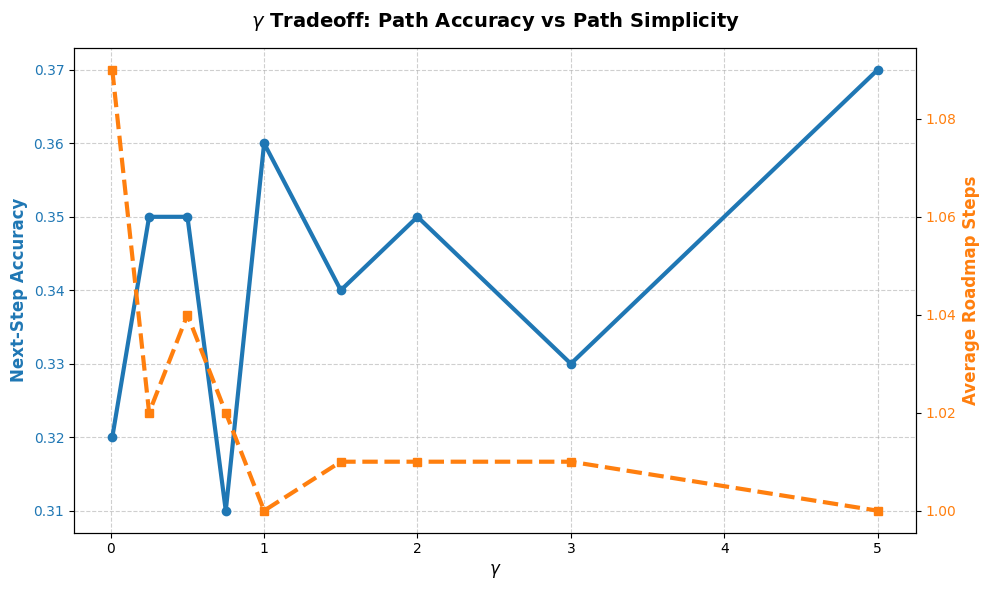

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy curve (blue)
line1 = ax1.plot(
    long_term_results["gamma"],
    long_term_results["Accuracy"],
    color="tab:blue",
    marker="o",
    linewidth=3,
    label="Next-Step Accuracy"
)
ax1.set_xlabel("Gamma", fontsize=12, fontweight="bold")
ax1.set_ylabel("Next-Step Accuracy", color="tab:blue", fontsize=12, fontweight="bold")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, linestyle="--", alpha=0.6)

# Steps curve (orange)
ax2 = ax1.twinx()
line2 = ax2.plot(
    long_term_results["gamma"],
    long_term_results["Avg Steps"],
    color="tab:orange",
    marker="s",
    linestyle="--",
    linewidth=3,
    label="Average Roadmap Steps"
)
ax2.set_ylabel("Average Roadmap Steps", color="tab:orange", fontsize=12, fontweight="bold")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.set_xlabel(r"$\gamma$", fontsize=12, fontweight="bold")

plt.title(
    r"$\gamma$ Tradeoff: Path Accuracy vs Path Simplicity",
    fontsize=14,
    fontweight="bold",
    pad=15
)

plt.tight_layout()
plt.show()
